# Jak przewidzieć wiele szeregów czasowych jednocześnie za pomocą Scikit-Learn (z przykładem prognozowania sprzedaży)

Masz wiele punktów danych szeregów czasowych i chcesz przewidzieć następny krok (lub kroki). Co powinieneś teraz zrobić? Wytrenuj model dla każdej serii? Czy jest sposób na dopasowanie modelu do wszystkich serii razem? Co jest lepsze?

Widziałem wielu analityków danych, którzy zastanawiali się nad podejściem do tego problemu, tworząc jeden model dla każdego produktu. Chociaż jest to jedno z możliwych rozwiązań, prawdopodobnie nie będzie najlepsze.

W tym miejscu pokażę, jak wytrenować pojedynczy model do prognozowania wielu szeregów czasowych w tym samym czasie. Ta technika zwykle tworzy potężne modele, które pomagają zespołom wygrywać konkursy na uczenie maszynowe i można je wykorzystać w projekcie.

I nie potrzebujesz do tego modeli głębokiego uczenia!

# Indywidualne modele uczenia maszynowego a duży model dla wszystkiego

W uczeniu maszynowym więcej danych zwykle oznacza lepsze prognozy. Jeśli spróbujesz stworzyć jeden model dla każdej serii, będziesz miał pewne problemy z seriami, które zawierają niewiele danych lub nie zawierają ich wcale.

Gdy łączysz wszystkie serie w jeden zestaw danych, aby wytrenować jeden model, używasz znacznie więcej danych. Może to pomóc modelowi lepiej działać!

Biorąc pod uwagę więcej niż jedną serię na raz, algorytmy uczenia maszynowego będą w stanie nauczyć się bardziej subtelnych wzorców, które powtarzają się w różnych seriach. Produkt staje się zmienną w naszym modelu.

Najpierw zaimportujmy nasze podstawowe narzędzia:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor



df = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv")
#print(is.data.frame(df))
#print(ncol(df))
#print(nrow(df))
#print(names(df))
df

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0.00,0.33,0.33,0.00,0.00,0.33,0.00,0.00,0.67,0.00
807,P816,0,1,0,0,1,2,2,6,0,...,0.43,0.43,0.57,0.29,0.57,0.71,0.71,0.71,0.86,0.71
808,P817,1,0,0,0,1,1,2,1,1,...,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.75
809,P818,0,0,0,1,0,0,0,0,1,...,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.00


# Przygotowanie danych
Dane zostały pozyskane z Repozytorium UCI.

Tutaj postaramy się prognozować sprzedaż dla 811 produktów. Nasz zbiór danych zawiera rekordy sprzedaży z 52 tygodni dla każdego z produktów.

Oznacza to, że pierwotnie mamy 811 szeregów czasowych z 52 punktami danych każdy. Tutaj biorę tylko kod produktu i nieznormalizowaną tygodniową sprzedaż dla każdego produktu.

Tak wyglądają dane:

In [2]:
data = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv")
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


W tym momencie wielu analityków danych próbowałoby dopasować model do każdego produktu. I chociaż może to działać dobrze, możemy mieć problemy z powodu posiadania tylko 52 punktów danych dla każdego modelu, co jest naprawdę niskie!

Ponieważ modele uczenia maszynowego mają tendencję do ulepszania się przy większej ilości danych, dlaczego nie spróbować połączyć wszystkich serii i wytrenować jednego modelu z większą ilością danych?

Aby to zrobić, musimy „stopić” dane. Oznacza to po prostu przekształcenie danych w taki sposób, w jaki każda linia staje się: kodem produktu, tygodniem, sprzedażą

Aby ułatwić nam życie, postanowiłem usunąć litery z kodu produktu i tygodnia.

In [3]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
melt

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


In [4]:
melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Product_Code']

0          1
1          2
2          3
3          4
4          5
        ... 
42167    815
42168    816
42169    817
42170    818
42171    819
Name: Product_Code, Length: 42172, dtype: int64

In [5]:
melt

,Product_Code,Week,Sales
0,1,W0,11
1,2,W0,7
2,3,W0,7
3,4,W0,12
4,5,W0,8
...,...,...,...
42167,815,W51,0
42168,816,W51,5
42169,817,W51,3
42170,818,W51,0


In [6]:
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)
melt

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
...,...,...,...
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0


In [7]:
melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [8]:
melt.shape

(42172, 3)

Teraz mamy 42172 wiersze do trenowania naszego modelu.

# Podstawowa inżynieria funkcji

Potrzebujemy zmiennych do wysłania do naszego modelu i uzyskania prognoz. 
Na razie, oprócz kodu produktu i tygodnia, stworzę dwie funkcje, które zwykle bardzo pomagają w prognozowaniu szeregów czasowych: opóźnienia i różnice.

Sprzedaż w zeszłym tygodniu: jest to po prostu kwota sprzedaży, jaką produkt miał w poprzednim tygodniu
Różnica z ostatniego tygodnia: różnica między wielkością sprzedaży w poprzednim tygodniu i tygodniu poprzedzającym (t-1 - t-2)

In [9]:
melt2 = melt.copy() ## skopiował df

In [10]:
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift() ## zrobił przesunięcie o jeden
#df[df.iso_country.isin(['CZ','SK','PL'])&(df.type =='large_airport')]

melt2[melt2.Week.isin([7,8,9,10,11,12,13])&(melt2.Product_Code ==2)][['Product_Code','Sales','Last_Week_Sales']] 
#melt2[['Sales','Last_Week_Sales']]

,Product_Code,Sales,Last_Week_Sales
5678,2,3,6.0
6489,2,3,3.0
7300,2,3,3.0
8111,2,2,3.0
8922,2,2,2.0
9733,2,6,2.0
10544,2,2,6.0


In [11]:
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff() # różnica między kolejnymi dniami np. 6-2 = 4

In [12]:
melt2[melt2.Week.isin([7,8,9,10,11,12,13])&(melt2.Product_Code ==2)]

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
5678,2,7,3,6.0,5.0
6489,2,8,3,3.0,-3.0
7300,2,9,3,3.0,0.0
8111,2,10,2,3.0,0.0
8922,2,11,2,2.0,-1.0
9733,2,12,6,2.0,0.0
10544,2,13,2,6.0,4.0


In [13]:
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
0,1,0,11,NaN,NaN
1,2,0,7,NaN,NaN
2,3,0,7,NaN,NaN
3,4,0,12,NaN,NaN
4,5,0,8,NaN,NaN


In [14]:
melt2 = melt2.dropna()  # wykasowane wszystkie wiersze zawierające NaN
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


# Ocena wyniku

Aby wiedzieć, czy nasz model jest dobry, potrzebujemy metryki oceny. Miarą, którą bardzo lubię w prognozowaniu sprzedaży, jest błąd logarytmu średniokwadratowego.

To jest nasz dobrze znany RMSE zastosowany do dziennika celu i wyniku prognozy.

Działa jako przybliżenie błędu procentowego między naszym modelem prognozowania a wartością docelową, co jest dobrym sposobem na zrozumienie błędów popełnianych przez nasz model.

In [15]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Ustawianie linii bazowej i podziału walidacji

Załóżmy, że w prawdziwym życiu Twój model będzie działał w każdą niedzielę wieczorem, aby już w poniedziałek menedżerowie mogli podejmować decyzje na podstawie przewidywań na następny tydzień.

Aby sprawdzić, czy nasz model będzie działał w tym scenariuszu, tygodni, których wcześniej nie widział, użyję walidacji z przesuwnym oknem.

### Oznacza to, że będziemy symulować trenowanie modelu we wszystkich tygodniach aż do tego, który chcemy prognozować i oceniać nasz wynik w nowym tygodniu.

Aby uniknąć posiadania bardzo dobrego modelu w ciągu niewielkiej liczby tygodni, po prostu ze względu na szczęście, będę używał tygodni od 40 do 52, powtarzając proces dla jednego na raz (za kazdym razem) i obliczając wynik.

Ponieważ jest to tylko demonstracja metody, dla uproszczenia nie oddzielam zestawu testowego. W swoich projektach zawsze trzymaj pewne okresy poza walidacją, aby ocenić swój model po zakończeniu jego opracowywania.

Jest to bardzo ważne i zapewnia większe bezpieczeństwo podczas wdrażania modelu.

Aby upewnić się, że model jest wart zastosowania, lubię ustalać punktację bazową, którą musi pokonać. W tym przypadku dość silna linia bazowa wykorzystuje sprzedaż z ostatniego tygodnia jako prognozę sprzedaży w tym tygodniu.

In [16]:
for week in range(4,5):
    train = melt2[melt2['Week'] < week] ## wszystkie weekendy porzed 4 weekendem
    val = melt2[melt2['Week'] == week]  ## wszystkie weekendy mniejsze do 5 i równe 4
train

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0
...,...,...,...,...,...
3239,815,3,0,1.0,1.0
3240,816,3,0,0.0,-1.0
3241,817,3,0,0.0,0.0
3242,818,3,1,0.0,0.0


In [17]:
val  # wszystkie weekendy mniejsze do 5 i równe 4

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
3244,1,4,13,8.0,-2.0
3245,2,4,7,2.0,-1.0
3246,3,4,10,9.0,1.0
3247,4,4,9,5.0,-8.0
3248,5,4,6,11.0,-2.0
...,...,...,...,...,...
4050,815,4,0,0.0,-1.0
4051,816,4,1,0.0,0.0
4052,817,4,1,0.0,0.0
4053,818,4,0,1.0,1.0


In [18]:
for week in range(4,5):
    train = melt2[melt2['Week'] < week]  ## wszystkie weekendy porzed 40 weekendem
    val = melt2[melt2['Week'] == week]   ## wszystkie weekendy od 40 do 51 weekend

    p = val['Last_Week_Sales'].values     ## to poprostu wylistowanie wektora 'Last_Week_Sales'
p

array([ 8.,  2.,  9.,  5., 11.,  7.,  7.,  9.,  7., 29., 14.,  6.,  6.,
       11., 42., 43., 28., 38., 36., 10.,  8.,  9.,  3., 33., 32.,  8.,
       39., 41., 17., 34.,  7.,  4., 17., 55., 27., 45., 42., 52., 39.,
       51., 43., 27., 43., 36., 34., 38., 28., 33., 38.,  8., 27., 48.,
        8., 40., 42., 36., 43., 41., 11., 27., 47., 22., 44., 42., 10.,
       34., 44.,  9., 39., 31.,  8., 41., 46., 15., 27., 45.,  2., 39.,
       41., 40.,  5., 13., 38., 39., 38., 32., 39., 30., 31., 39., 13.,
       40., 13.,  9., 13., 44., 40.,  4., 21.,  9., 47., 32.,  7.,  5.,
        2., 16., 24.,  0.,  5.,  6.,  4., 51., 37.,  8., 13.,  8.,  3.,
       10., 33., 30., 10.,  8.,  6.,  7., 10.,  3.,  2., 39., 47., 41.,
       35., 41., 38., 35., 37., 52., 41., 35., 38., 46., 34., 43., 42.,
       12.,  9., 13.,  9.,  3.,  6.,  4.,  8.,  8., 10.,  6.,  3.,  6.,
        7.,  2.,  5., 13.,  7.,  9.,  6.,  9., 16., 11., 41., 59., 43.,
       43.,  6., 40., 47., 43., 28., 26., 48., 36., 36., 43., 38

Teraz wiemy, że nasz model musi mieć lepszy błąd niż około 0,51. Byłoby to około 50% błędu w każdej prognozie, co wydaje się ogromne! Ale czy to naprawdę?

Jeśli przyjrzymy się rozkładowi sprzedaży w zbiorze danych, zobaczymy, że wiele przedmiotów sprzedaje bardzo małe ilości. Powinniśmy więc oczekiwać, że błąd będzie wyglądał na „wysoki”.

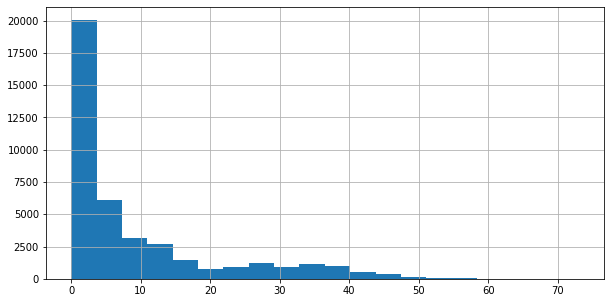

In [19]:
melt2['Sales'].hist(bins=20, figsize=(10,5))

# Tworzenie modelu

Teraz, gdy mamy linię bazową, spróbujmy ją pokonać!

Jako pierwszy model wytrenujmy Losowy Las. Poza tym, że jesteśmy silnym modelem z ustrukturyzowanymi danymi (takimi jak ten, które mamy), zwykle możemy już uzyskać bardzo dobry wynik, po prostu ustawiając dużą liczbę drzew.

Zwykle mówię analitykom danych, że Losowy Las to bardzo dobry model do wykorzystania w leniwy dzień. Ustawiasz tylko liczbę drzew na maksymalną, którą twój komputer może uruchomić i uzyskać dobry model (miejmy nadzieję).

Zostanę Tydzień jako funkcję, chociaż nasz model nigdy nie widział nowej wartości tygodnia. Może się zdarzyć, że np. po 35 tygodniu mamy większą sprzedaż produktu. Ten rodzaj efektu może zostać uchwycony przez model.

Ponieważ drzewa decyzyjne dobrze radzą sobie z cechami kategorialnymi nawet w kodowaniu porządkowym, zostawiłem je w tym formacie.

W każdym razie bądź ostrożny z tego typu funkcjami.



# SUPER!

Stosując Losowy Las do naszych początkowych zmiennych, uzyskaliśmy dobrą redukcję błędu (około 10%). To bardzo dobry sposób na rozpoczęcie.

Teraz spróbujmy dodać kilka funkcji sprzed kilku tygodni. Najpierw dodajmy opóźnienie i różnicę sprzedaży na tydzień przed poprzednim.

In [20]:
melt3 = melt.copy()
melt3['Last_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt3['Last-1_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


# WspaniaLE! Kolejna obniżka!

Czy możesz odgadnąć mój następny pomysł?

Wypróbujmy oczywiście model z jeszcze jednym opóźnieniem i różnicą!

In [21]:
melt4 = melt.copy()
melt4['Last_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt4['Last-1_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt4['Last-2_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


In [22]:
melt4

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0
...,...,...,...,...,...,...,...,...,...
42167,815,51,0,2.0,2.0,0.0,0.0,0.0,-1.0
42168,816,51,5,6.0,1.0,5.0,0.0,5.0,0.0
42169,817,51,3,4.0,4.0,0.0,0.0,0.0,0.0
42170,818,51,0,2.0,2.0,0.0,0.0,0.0,0.0


In [23]:
for week in range(36,42):
    train = melt4[melt4['Week'] < week]   ## okres treningowy do 36 tygodnia
    val = melt4[melt4['Week'] == week]    ## okres testowy od 36 tygodnia włącznie do 42 tygodnia 
                                        ## 43-52 tydzień to okres super testowy

    Xtrain, Xtest = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)  # podział na zmienne treningowe i testowe
    ytrain, ytest = train['Sales'].values, val['Sales'].values                  # podział na wyniki testowe i treningowe 

# Jak przewidzieć wiele szeregów czasowych jednocześnie za pomocą Scikit-Learn (z przykładem prognozowania sprzedaży)

Masz wiele punktów danych szeregów czasowych i chcesz przewidzieć następny krok (lub kroki). Co powinieneś teraz zrobić? Wytrenuj model dla każdej serii? Czy jest sposób na dopasowanie modelu do wszystkich serii razem? Co jest lepsze?

Widziałem wielu analityków danych, którzy zastanawiali się nad podejściem do tego problemu, tworząc jeden model dla każdego produktu. Chociaż jest to jedno z możliwych rozwiązań, prawdopodobnie nie będzie najlepsze.

W tym miejscu pokażę, jak wytrenować pojedynczy model do prognozowania wielu szeregów czasowych w tym samym czasie. Ta technika zwykle tworzy potężne modele, które pomagają zespołom wygrywać konkursy na uczenie maszynowe i można je wykorzystać w projekcie.

I nie potrzebujesz do tego modeli głębokiego uczenia!

# Indywidualne modele uczenia maszynowego a duży model dla wszystkiego

W uczeniu maszynowym więcej danych zwykle oznacza lepsze prognozy. Jeśli spróbujesz stworzyć jeden model dla każdej serii, będziesz miał pewne problemy z seriami, które zawierają niewiele danych lub nie zawierają ich wcale.

Gdy łączysz wszystkie serie w jeden zestaw danych, aby wytrenować jeden model, używasz znacznie więcej danych. Może to pomóc modelowi lepiej działać!

Biorąc pod uwagę więcej niż jedną serię na raz, algorytmy uczenia maszynowego będą w stanie nauczyć się bardziej subtelnych wzorców, które powtarzają się w różnych seriach. Produkt staje się zmienną w naszym modelu.

Najpierw zaimportujmy nasze podstawowe narzędzia:

In [24]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor



df = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv")
#print(is.data.frame(df))
#print(ncol(df))
#print(nrow(df))
#print(names(df))
df

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0.00,0.33,0.33,0.00,0.00,0.33,0.00,0.00,0.67,0.00
807,P816,0,1,0,0,1,2,2,6,0,...,0.43,0.43,0.57,0.29,0.57,0.71,0.71,0.71,0.86,0.71
808,P817,1,0,0,0,1,1,2,1,1,...,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.75
809,P818,0,0,0,1,0,0,0,0,1,...,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.00


# Przygotowanie danych
Dane zostały pozyskane z Repozytorium UCI.

Tutaj postaramy się prognozować sprzedaż dla 811 produktów. Nasz zbiór danych zawiera rekordy sprzedaży z 52 tygodni dla każdego z produktów.

Oznacza to, że pierwotnie mamy 811 szeregów czasowych z 52 punktami danych każdy. Tutaj biorę tylko kod produktu i nieznormalizowaną tygodniową sprzedaż dla każdego produktu.

Tak wyglądają dane:

In [25]:
data = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv")
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


W tym momencie wielu analityków danych próbowałoby dopasować model do każdego produktu. I chociaż może to działać dobrze, możemy mieć problemy z powodu posiadania tylko 52 punktów danych dla każdego modelu, co jest naprawdę niskie!

Ponieważ modele uczenia maszynowego mają tendencję do ulepszania się przy większej ilości danych, dlaczego nie spróbować połączyć wszystkich serii i wytrenować jednego modelu z większą ilością danych?

Aby to zrobić, musimy „stopić” dane. Oznacza to po prostu przekształcenie danych w taki sposób, w jaki każda linia staje się: kodem produktu, tygodniem, sprzedażą

Aby ułatwić nam życie, postanowiłem usunąć litery z kodu produktu i tygodnia.

In [26]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
melt

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


In [27]:
melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Product_Code']

0          1
1          2
2          3
3          4
4          5
        ... 
42167    815
42168    816
42169    817
42170    818
42171    819
Name: Product_Code, Length: 42172, dtype: int64

In [28]:
melt

,Product_Code,Week,Sales
0,1,W0,11
1,2,W0,7
2,3,W0,7
3,4,W0,12
4,5,W0,8
...,...,...,...
42167,815,W51,0
42168,816,W51,5
42169,817,W51,3
42170,818,W51,0


In [29]:
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)
melt

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
...,...,...,...
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0


In [30]:
melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [31]:
melt.shape

(42172, 3)

Teraz mamy 42172 wiersze do trenowania naszego modelu.

# Podstawowa inżynieria funkcji

Potrzebujemy zmiennych do wysłania do naszego modelu i uzyskania prognoz. 
Na razie, oprócz kodu produktu i tygodnia, stworzę dwie funkcje, które zwykle bardzo pomagają w prognozowaniu szeregów czasowych: opóźnienia i różnice.

Sprzedaż w zeszłym tygodniu: jest to po prostu kwota sprzedaży, jaką produkt miał w poprzednim tygodniu
Różnica z ostatniego tygodnia: różnica między wielkością sprzedaży w poprzednim tygodniu i tygodniu poprzedzającym (t-1 - t-2)

In [32]:
melt2 = melt.copy() ## skopiował df

In [33]:
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift() ## zrobił przesunięcie o jeden
#df[df.iso_country.isin(['CZ','SK','PL'])&(df.type =='large_airport')]

melt2[melt2.Week.isin([7,8,9,10,11,12,13])&(melt2.Product_Code ==2)][['Product_Code','Sales','Last_Week_Sales']] 
#melt2[['Sales','Last_Week_Sales']]

,Product_Code,Sales,Last_Week_Sales
5678,2,3,6.0
6489,2,3,3.0
7300,2,3,3.0
8111,2,2,3.0
8922,2,2,2.0
9733,2,6,2.0
10544,2,2,6.0


In [34]:
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff() # różnica między kolejnymi dniami np. 6-2 = 4

In [35]:
melt2[melt2.Week.isin([7,8,9,10,11,12,13])&(melt2.Product_Code ==2)]

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
5678,2,7,3,6.0,5.0
6489,2,8,3,3.0,-3.0
7300,2,9,3,3.0,0.0
8111,2,10,2,3.0,0.0
8922,2,11,2,2.0,-1.0
9733,2,12,6,2.0,0.0
10544,2,13,2,6.0,4.0


In [36]:
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
0,1,0,11,NaN,NaN
1,2,0,7,NaN,NaN
2,3,0,7,NaN,NaN
3,4,0,12,NaN,NaN
4,5,0,8,NaN,NaN


In [37]:
melt2 = melt2.dropna()  # wykasowane wszystkie wiersze zawierające NaN
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


# Ocena wyniku

Aby wiedzieć, czy nasz model jest dobry, potrzebujemy metryki oceny. Miarą, którą bardzo lubię w prognozowaniu sprzedaży, jest błąd logarytmu średniokwadratowego.

To jest nasz dobrze znany RMSE zastosowany do dziennika celu i wyniku prognozy.

Działa jako przybliżenie błędu procentowego między naszym modelem prognozowania a wartością docelową, co jest dobrym sposobem na zrozumienie błędów popełnianych przez nasz model.

In [38]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Ustawianie linii bazowej i podziału walidacji

Załóżmy, że w prawdziwym życiu Twój model będzie działał w każdą niedzielę wieczorem, aby już w poniedziałek menedżerowie mogli podejmować decyzje na podstawie przewidywań na następny tydzień.

Aby sprawdzić, czy nasz model będzie działał w tym scenariuszu, tygodni, których wcześniej nie widział, użyję walidacji z przesuwnym oknem.

### Oznacza to, że będziemy symulować trenowanie modelu we wszystkich tygodniach aż do tego, który chcemy prognozować i oceniać nasz wynik w nowym tygodniu.

Aby uniknąć posiadania bardzo dobrego modelu w ciągu niewielkiej liczby tygodni, po prostu ze względu na szczęście, będę używał tygodni od 40 do 52, powtarzając proces dla jednego na raz (za kazdym razem) i obliczając wynik.

Ponieważ jest to tylko demonstracja metody, dla uproszczenia nie oddzielam zestawu testowego. W swoich projektach zawsze trzymaj pewne okresy poza walidacją, aby ocenić swój model po zakończeniu jego opracowywania.

Jest to bardzo ważne i zapewnia większe bezpieczeństwo podczas wdrażania modelu.

Aby upewnić się, że model jest wart zastosowania, lubię ustalać punktację bazową, którą musi pokonać. W tym przypadku dość silna linia bazowa wykorzystuje sprzedaż z ostatniego tygodnia jako prognozę sprzedaży w tym tygodniu.

In [39]:
for week in range(4,5):
    train = melt2[melt2['Week'] < week] ## wszystkie weekendy porzed 4 weekendem
    val = melt2[melt2['Week'] == week]  ## wszystkie weekendy mniejsze do 5 i równe 4
train

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0
...,...,...,...,...,...
3239,815,3,0,1.0,1.0
3240,816,3,0,0.0,-1.0
3241,817,3,0,0.0,0.0
3242,818,3,1,0.0,0.0


In [40]:
val  # wszystkie weekendy mniejsze do 5 i równe 4

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
3244,1,4,13,8.0,-2.0
3245,2,4,7,2.0,-1.0
3246,3,4,10,9.0,1.0
3247,4,4,9,5.0,-8.0
3248,5,4,6,11.0,-2.0
...,...,...,...,...,...
4050,815,4,0,0.0,-1.0
4051,816,4,1,0.0,0.0
4052,817,4,1,0.0,0.0
4053,818,4,0,1.0,1.0


In [41]:
for week in range(4,5):
    train = melt2[melt2['Week'] < week]  ## wszystkie weekendy porzed 40 weekendem
    val = melt2[melt2['Week'] == week]   ## wszystkie weekendy od 40 do 51 weekend

    p = val['Last_Week_Sales'].values     ## to poprostu wylistowanie wektora 'Last_Week_Sales'
p

array([ 8.,  2.,  9.,  5., 11.,  7.,  7.,  9.,  7., 29., 14.,  6.,  6.,
       11., 42., 43., 28., 38., 36., 10.,  8.,  9.,  3., 33., 32.,  8.,
       39., 41., 17., 34.,  7.,  4., 17., 55., 27., 45., 42., 52., 39.,
       51., 43., 27., 43., 36., 34., 38., 28., 33., 38.,  8., 27., 48.,
        8., 40., 42., 36., 43., 41., 11., 27., 47., 22., 44., 42., 10.,
       34., 44.,  9., 39., 31.,  8., 41., 46., 15., 27., 45.,  2., 39.,
       41., 40.,  5., 13., 38., 39., 38., 32., 39., 30., 31., 39., 13.,
       40., 13.,  9., 13., 44., 40.,  4., 21.,  9., 47., 32.,  7.,  5.,
        2., 16., 24.,  0.,  5.,  6.,  4., 51., 37.,  8., 13.,  8.,  3.,
       10., 33., 30., 10.,  8.,  6.,  7., 10.,  3.,  2., 39., 47., 41.,
       35., 41., 38., 35., 37., 52., 41., 35., 38., 46., 34., 43., 42.,
       12.,  9., 13.,  9.,  3.,  6.,  4.,  8.,  8., 10.,  6.,  3.,  6.,
        7.,  2.,  5., 13.,  7.,  9.,  6.,  9., 16., 11., 41., 59., 43.,
       43.,  6., 40., 47., 43., 28., 26., 48., 36., 36., 43., 38

Teraz wiemy, że nasz model musi mieć lepszy błąd niż około 0,51. Byłoby to około 50% błędu w każdej prognozie, co wydaje się ogromne! Ale czy to naprawdę?

Jeśli przyjrzymy się rozkładowi sprzedaży w zbiorze danych, zobaczymy, że wiele przedmiotów sprzedaje bardzo małe ilości. Powinniśmy więc oczekiwać, że błąd będzie wyglądał na „wysoki”.

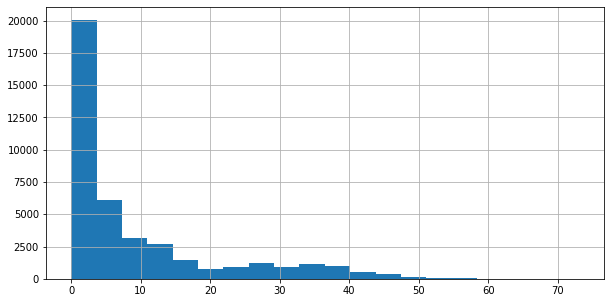

In [42]:
melt2['Sales'].hist(bins=20, figsize=(10,5))

# Tworzenie modelu

Teraz, gdy mamy linię bazową, spróbujmy ją pokonać!

Jako pierwszy model wytrenujmy Losowy Las. Poza tym, że jesteśmy silnym modelem z ustrukturyzowanymi danymi (takimi jak ten, które mamy), zwykle możemy już uzyskać bardzo dobry wynik, po prostu ustawiając dużą liczbę drzew.

Zwykle mówię analitykom danych, że Losowy Las to bardzo dobry model do wykorzystania w leniwy dzień. Ustawiasz tylko liczbę drzew na maksymalną, którą twój komputer może uruchomić i uzyskać dobry model (miejmy nadzieję).

Zostanę Tydzień jako funkcję, chociaż nasz model nigdy nie widział nowej wartości tygodnia. Może się zdarzyć, że np. po 35 tygodniu mamy większą sprzedaż produktu. Ten rodzaj efektu może zostać uchwycony przez model.

Ponieważ drzewa decyzyjne dobrze radzą sobie z cechami kategorialnymi nawet w kodowaniu porządkowym, zostawiłem je w tym formacie.

W każdym razie bądź ostrożny z tego typu funkcjami.



# SUPER!

Stosując Losowy Las do naszych początkowych zmiennych, uzyskaliśmy dobrą redukcję błędu (około 10%). To bardzo dobry sposób na rozpoczęcie.

Teraz spróbujmy dodać kilka funkcji sprzed kilku tygodni. Najpierw dodajmy opóźnienie i różnicę sprzedaży na tydzień przed poprzednim.

In [43]:
melt3 = melt.copy()
melt3['Last_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt3['Last-1_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


# WspaniaLE! Kolejna obniżka!

Czy możesz odgadnąć mój następny pomysł?

Wypróbujmy oczywiście model z jeszcze jednym opóźnieniem i różnicą!

In [44]:
melt4 = melt.copy()
melt4['Last_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt4['Last-1_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt4['Last-2_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


In [45]:
melt4

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0
...,...,...,...,...,...,...,...,...,...
42167,815,51,0,2.0,2.0,0.0,0.0,0.0,-1.0
42168,816,51,5,6.0,1.0,5.0,0.0,5.0,0.0
42169,817,51,3,4.0,4.0,0.0,0.0,0.0,0.0
42170,818,51,0,2.0,2.0,0.0,0.0,0.0,0.0


In [46]:
for week in range(36,42):
    train = melt4[melt4['Week'] < week]   ## okres treningowy do 36 tygodnia
    val = melt4[melt4['Week'] == week]    ## okres testowy od 36 tygodnia włącznie do 42 tygodnia 
                                        ## 43-52 tydzień to okres super testowy

    Xtrain, Xtest = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)  # podział na zmienne treningowe i testowe
    ytrain, ytest = train['Sales'].values, val['Sales'].values                  # podział na wyniki testowe i treningowe 

### I specify what is X and what is y

### <span style="color:green"> Określam co jest X a co y

<span style="font-size: 110%;background:##ffe599">Wynik (ilość rowerów wypożyczonych) przed skalowaniem</span>  

In [47]:
ytrain[:5]

array([13,  7, 10,  9,  6])

In [48]:
ytest[:5]

array([11,  5,  5,  6,  8])

<span style="font-size: 110%;background:##ffe599">Zmienne opisujące przed skalowaniem

In [49]:
Xtrain[:5]

,Product_Code,Week,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,11.0,-2.0,13.0,8.0,5.0,-3.0


In [50]:
Xtest[:5]

,Product_Code,Week,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
33251,1,41,7.0,-10.0,17.0,5.0,12.0,3.0
33252,2,41,2.0,-1.0,3.0,-4.0,7.0,5.0
33253,3,41,3.0,-6.0,9.0,-3.0,12.0,0.0
33254,4,41,12.0,4.0,8.0,0.0,8.0,2.0
33255,5,41,5.0,0.0,5.0,-3.0,8.0,0.0


### Scaling (normalization) of the X value

X should never be too big. Ideally, it should be in the range [-1, 1]. If this is not the case, normalize the input.

### <span style="color:green"> Skalowanie (normalizacja) wartości X

<span style="color:green"> X nigdy nie powinien być zbyt duży. Idealnie powinien być w zakresie [-1, 1]. Jeśli tak nie jest, należy znormalizować dane wejściowe.

In [51]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)

print(np.round(Xtrain.std(), decimals=2), np.round(Xtrain.mean(), decimals=2))

1.0 0.0


In [52]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
Xtest = sc.fit_transform(Xtest)

print(np.round(Xtest.std(), decimals=2), np.round(Xtest.mean(), decimals=2))

0.94 -0.0


In [53]:
ytrain = (ytrain / 100)  # max test score is 100
#print(y.head(3))
print(np.round(ytrain.std(), decimals=2), np.round(ytrain.mean(), decimals=2))

0.12 0.09


In [54]:
ytest = (ytest / 100)  # max test score is 100
#print(y.head(3))
print(np.round(ytest.std(), decimals=2), np.round(ytest.mean(), decimals=2))

0.11 0.08


### Creates random input and output

### <span style="color:green"> Tworzy losowe dane wejściowe i wyjściowe 

In [55]:
import torch
import numpy as np

#X = X.values       #- jak była normalizacja to to nie działa
Xtrain = torch.tensor(Xtrain)
print(Xtrain[:3])

tensor([[-1.7224e+00, -1.6859e+00, -8.0567e-02, -4.1965e-01,  7.9306e-02,
         -4.2180e-01,  2.3935e-01,  2.1759e-01],
        [-1.7182e+00, -1.6859e+00, -5.7076e-01, -2.0571e-01, -4.8985e-01,
         -6.3523e-01, -2.4719e-01, -2.0806e-01],
        [-1.7140e+00, -1.6859e+00,  1.1326e-03,  2.2218e-01, -8.3311e-02,
         -6.3523e-01,  1.5826e-01,  8.5608e-01]], dtype=torch.float64)


In [56]:
Xtrain = Xtrain.type(torch.FloatTensor)
print(Xtrain[:3])

tensor([[-1.7224e+00, -1.6859e+00, -8.0567e-02, -4.1965e-01,  7.9306e-02,
         -4.2180e-01,  2.3935e-01,  2.1759e-01],
        [-1.7182e+00, -1.6859e+00, -5.7076e-01, -2.0571e-01, -4.8985e-01,
         -6.3523e-01, -2.4719e-01, -2.0806e-01],
        [-1.7140e+00, -1.6859e+00,  1.1326e-03,  2.2218e-01, -8.3311e-02,
         -6.3523e-01,  1.5826e-01,  8.5608e-01]])


In [57]:
#X = X.values       #- jak była normalizacja to to nie działa
Xtest = torch.tensor(Xtest)
print(Xtest[:3])

tensor([[-1.7224,  0.0000, -0.1068, -2.4464,  0.8403,  1.2700,  0.3327,  0.6765],
        [-1.7182,  0.0000, -0.5584, -0.2914, -0.4618, -0.8923, -0.1111,  1.1559],
        [-1.7140,  0.0000, -0.4681, -1.4886,  0.0962, -0.6520,  0.3327, -0.0426]],
       dtype=torch.float64)


In [58]:
Xtest = Xtest.type(torch.FloatTensor)
print(Xtest[:3])

tensor([[-1.7224,  0.0000, -0.1068, -2.4464,  0.8403,  1.2700,  0.3327,  0.6765],
        [-1.7182,  0.0000, -0.5584, -0.2914, -0.4618, -0.8923, -0.1111,  1.1559],
        [-1.7140,  0.0000, -0.4681, -1.4886,  0.0962, -0.6520,  0.3327, -0.0426]])


In [59]:
ytrain = torch.tensor(ytrain)
print(ytrain[:3])

tensor([0.1300, 0.0700, 0.1000], dtype=torch.float64)


In [60]:
ytest = torch.tensor(ytest)
print(ytest[:3])

tensor([0.1100, 0.0500, 0.0500], dtype=torch.float64)


### TRanspends the resulting vector to become a column
### <span style="color:green"> TRansponuje wektor wynikowy aby stał się kolumną</span>
# ZMIENNE TRENINGOWE

In [61]:
ytrain = ytrain.type(torch.FloatTensor)

In [62]:
print('Xtrain:',Xtrain.shape)
print('ytrain:',ytrain.shape)

Xtrain: torch.Size([30007, 8])
ytrain: torch.Size([30007])


Dodanie jednego wymiaru do wektora wynikowego

In [63]:
ytrain = ytrain.view(ytrain.shape[0],1)
ytrain.shape

torch.Size([30007, 1])

In [64]:
Xtrain

tensor([[-1.7224e+00, -1.6859e+00, -8.0567e-02,  ..., -4.2180e-01,
          2.3935e-01,  2.1759e-01],
        [-1.7182e+00, -1.6859e+00, -5.7076e-01,  ..., -6.3523e-01,
         -2.4719e-01, -2.0806e-01],
        [-1.7140e+00, -1.6859e+00,  1.1326e-03,  ..., -6.3523e-01,
          1.5826e-01,  8.5608e-01],
        ...,
        [ 1.7308e+00,  1.6859e+00, -7.3416e-01,  ...,  5.0642e-03,
         -7.3373e-01,  4.7662e-03],
        [ 1.7351e+00,  1.6859e+00, -7.3416e-01,  ...,  5.0642e-03,
         -7.3373e-01,  4.7662e-03],
        [ 1.7393e+00,  1.6859e+00, -7.3416e-01,  ...,  5.0642e-03,
         -6.5264e-01,  4.7662e-03]])

# ZMIENNE TESTOWE

In [65]:
ytest = ytest.type(torch.FloatTensor)

In [66]:
print('Xtest:',Xtest.shape)
print('ytest:',ytest.shape)

Xtest: torch.Size([811, 8])
ytest: torch.Size([811])


Dodanie jednego wymiaru do wektora wynikowego

In [67]:
ytest = ytest.view(ytest.shape[0],1)
ytest.shape

torch.Size([811, 1])

In [68]:
Xtest

tensor([[-1.7224,  0.0000, -0.1068,  ...,  1.2700,  0.3327,  0.6765],
        [-1.7182,  0.0000, -0.5584,  ..., -0.8923, -0.1111,  1.1559],
        [-1.7140,  0.0000, -0.4681,  ..., -0.6520,  0.3327, -0.0426],
        ...,
        [ 1.7308,  0.0000, -0.7390,  ...,  0.0687, -0.7325, -0.0426],
        [ 1.7351,  0.0000, -0.7390,  ...,  0.0687, -0.7325, -0.0426],
        [ 1.7393,  0.0000, -0.6487,  ..., -0.1715, -0.6437, -0.0426]])

### Podział na zbiór testowy i zbiór treningowy

In [69]:
print('Xtrain: ',Xtrain.shape)
print('Xtest:  ',Xtest.shape)
print('----------------------------------------------------')
print('ytrain: ',ytrain.shape)
print('ytest:  ',ytest.shape)

Xtrain:  torch.Size([30007, 8])
Xtest:   torch.Size([811, 8])
----------------------------------------------------
ytrain:  torch.Size([30007, 1])
ytest:   torch.Size([811, 1])


## Defining the neural network
##### Programowanie torch.nn.Module

In [70]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

##### Definicja krztałtu sieci

In [71]:
N, D_in = Xtrain.shape
N, D_out = ytrain.shape

H = 100                            ## liczba wymiarów warstwy wewnętrznej 
device = torch.device('cpu')

In [72]:
net = torch.nn.Sequential(
        torch.nn.Linear(D_in,  H),   # Warstwa WEJŚCIOA
        torch.nn.LeakyReLU(),
        torch.nn.Linear(H, H),        # warstwa wewnętrzna
        torch.nn.LeakyReLU(),
        torch.nn.Linear(H, D_out),    # warstwa wyjściowa
    ).to(device)  

In [73]:
net(Xtrain)

tensor([[ 0.0687],
        [ 0.0114],
        [ 0.0572],
        ...,
        [-0.0943],
        [-0.0943],
        [-0.0948]], grad_fn=<AddmmBackward>)

## Алгоритм оптимизации:

##### Optymalizator 
lr: Speed of learning -> The speed at which our model updates the weights in the cells each time backward propagation is carried out

lr: Szybkość uczenia się -> Szybkość, z jaką nasz model aktualizuje wagi w komórkach za każdym razem, gdy przeprowadzana jest wsteczna propagacja

In [74]:
#optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0, nesterov=False) #-2.401
#optimizer = torch.optim.SGD(net.parameters(), lr=0.1) #-4.086
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) #-5.298
#optimizer = torch.optim.Adamax(net.parameters(), lr=0.01) #-6.610
#optimizer = torch.optim.ASGD(net.parameters(), lr=0.01, lambd=0.0001, alpha=0.15, t0=000000.0) #-2.315
#optimizer = torch.optim.LBFGS(net.parameters(), lr=0.01, max_iter=20, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
#optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08) #-5.152
#optimizer = torch.optim.Rprop(net.parameters(), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))  #R2:-7.388

## Определение функции потерь
to jest R2 dla regresji

In [75]:
loss_func = torch.nn.MSELoss()

### Definiowanie procesu nauki i nauka

In [76]:
inputs = Xtrain                          #1. deklarujemy x i y do nauki
outputs = ytrain
for i in range(2000):                          #2. pętla 1050 powtórzeń (epok)
   prediction = net(inputs)
   loss = loss_func(prediction, outputs) 
   optimizer.zero_grad()
   loss.backward()        
   optimizer.step()       

   if i % 200 == 0:  
      print(i, loss.item())     # <=# wartości y, a funkcja straty zwraca Tensor zawierający stratę.



0 0.056664325296878815
200 0.0013927281834185123
400 0.001338444883003831
600 0.0012914832914248109
800 0.0012671801960095763
1000 0.0012230112915858626
1200 0.0012123165652155876
1400 0.0012352747144177556
1600 0.0011631811503320932
1800 0.0011700097238644958


### There are many potential reasons. Most likely exploding gradients. The two things to try first:

- Normalize the inputs
- Lower the learning rate




### <span style="color:green">Istnieje wiele potencjalnych przyczyn. Najprawdopodobniej wybuchające gradienty. Dwie rzeczy do wypróbowania w pierwszej kolejności:

 - <span style="color:green">- Normalizuj wejścia
 - <span style="color:green">- Obniż tempo uczenia się

###  Forecast based on the model
-  substitute the same equations that were in the model
-  The following loss result shows the last model sequence
-  Loss shows how much the model is wrong (loss = sum of error squares) after the last learning sequence

### <span style="color:green"> Prognoza na podstawie modelu
- <span style="color:green"> podstawiamy te same równania, które były w modelu 
- <span style="color:green"> Poniższy wynik loss pokazuje ostatnią sekwencje modelu
- <span style="color:green"> Loss pokazuje ile myli się model (loss = suma kwadratu błedów) po ostatniej sekwencji uczenia się 

<span style="font-size: 180%;background:##ffe599"> Podtsawiam pod model

In [77]:
with torch.no_grad():
    y_pred = net(Xtest)  
    loss = (y_pred - ytest).pow(2).sum()

    print(f'Loss train_set: {loss:.8f}')

Loss train_set: 1.15588164


<span style="color:green">Ponieważ ustaliliśmy, że nasza warstwa wyjściowa będzie zawierać 1 neuron, każda prognoza będzie zawierać 1 wartości. Przykładowo pierwsze 5 przewidywanych wartości wygląda następująco:

### We save the whole model

### <span style="color:green"> Zapisujemy cały model

In [78]:
torch.save(net,'/home/wojciech/Pulpit/7/byk17.pb')

### We play the whole model
### <span style="color:green"> Odtwarzamy cały model
    
    Model teraz nie nazywa się 'net' tylo 'KOT'

In [79]:
KOT = torch.load('/home/wojciech/Pulpit/7/byk17.pb')
KOT

Sequential(
  (0): Linear(in_features=8, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=100, out_features=1, bias=True)
)

In [80]:
with torch.no_grad():
    y_interp = KOT(Xtest)  
    loss = (y_interp - ytest).pow(2).mean()

    print(f'Loss train_set: {loss:.8f}')

Loss train_set: 0.00142525


In [81]:
y_interp

tensor([[0.1197],
        [0.0503],
        [0.1022],
        [0.0936],
        [0.0790],
        [0.0507],
        [0.0477],
        [0.0750],
        [0.1034],
        [0.1861],
        [0.0996],
        [0.0727],
        [0.0779],
        [0.1006],
        [0.3655],
        [0.3648],
        [0.3617],
        [0.3502],
        [0.3947],
        [0.0977],
        [0.0878],
        [0.1001],
        [0.0528],
        [0.3926],
        [0.3424],
        [0.0969],
        [0.3761],
        [0.3656],
        [0.1015],
        [0.3767],
        [0.0997],
        [0.0929],
        [0.0935],
        [0.3626],
        [0.3311],
        [0.3495],
        [0.3457],
        [0.3410],
        [0.3969],
        [0.3815],
        [0.3596],
        [0.3427],
        [0.3305],
        [0.3627],
        [0.3530],
        [0.3450],
        [0.3687],
        [0.3744],
        [0.3626],
        [0.0959],
        [0.1618],
        [0.3513],
        [0.0563],
        [0.3199],
        [0.3409],
        [0

### By substituting other independent variables, you can get a vector of output variables
We choose a random record from the tensor

### <span style="color:green">Podstawiając inne zmienne niezależne można uzyskać wektor zmiennych wyjściowych
<span style="color:green"> Wybieramy sobie jakąś losowy rekord z tensora

In [82]:
y_interp = y_interp*10
foka = y_interp.cpu().detach().numpy()
df11 = pd.DataFrame(foka)
df11.columns = ['y_interp']
df11=np.round(df11.y_interp)
df11.head(3)

0    1.0
1    1.0
2    1.0
Name: y_interp, dtype: float32

In [83]:
ytest = ytest*10
foka = ytest.cpu().detach().numpy()
df_t = pd.DataFrame(foka)
df_t.columns = ['y']
df_t.head(3)

,y
0,1.1
1,0.5
2,0.5


In [84]:
NOWA = pd.merge(df_t,df11, how='inner', left_index=True, right_index=True)
NOWA.head(3)

,y,y_interp
0,1.1,1.0
1,0.5,1.0
2,0.5,1.0


In [85]:
NOWA.to_csv('/home/wojciech/Pulpit/7/NOWA.csv')

Text(0.5, 1.0, 'COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

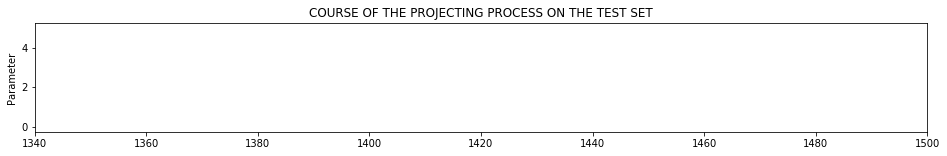

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=(16, 2))
for ewa in ['y', 'y_interp']:
    ax.plot(NOWA, label=ewa)
    
ax.set_xlim(1340, 1500)
#ax.legend()
ax.set_ylabel('Parameter')
ax.set_title('COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

<Figure size 432x288 with 0 Axes>

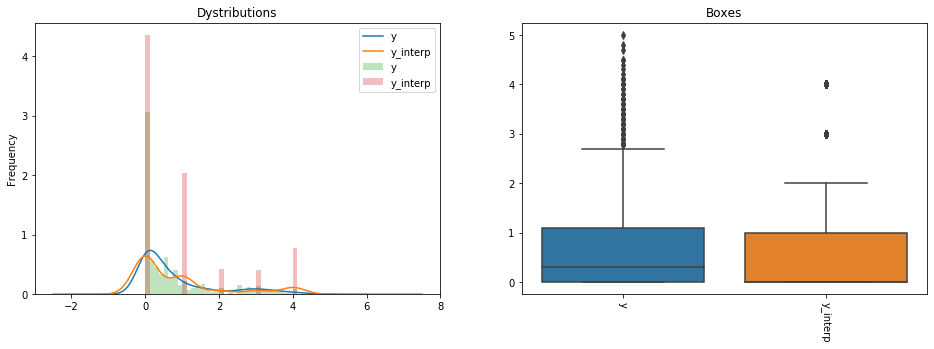

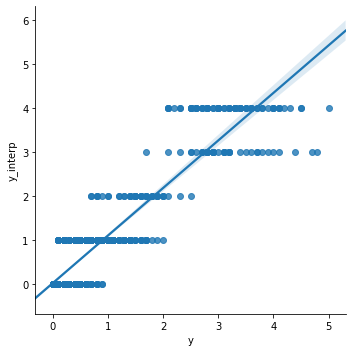

In [87]:
## marginesy
plt.subplots_adjust( left = None , bottom = None , right = None , top = None , wspace = None , hspace = None )
plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
NOWA.plot.kde(ax=ax, legend=True, title='Histogram: y vs. y_interp')
NOWA.plot.hist(density=True,bins=40, ax=ax, alpha=0.3)
ax.set_title("Dystributions")

ax = plt.subplot(1, 2, 2)
sns.boxplot(data = NOWA)
plt.xticks(rotation=-90)
ax.set_title("Boxes")


sns.lmplot(data=NOWA, x='y', y='y_interp')

# Regression_Assessment

In [88]:
## Robi ocenę tylko dla jednej zmiennej

def Regression_Assessment(y, y_pred):
    
    from sklearn.metrics import r2_score 
    import scipy.stats as stats
    from statsmodels.graphics.gofplots import qqplot
    from matplotlib import pyplot
       
    print('-----two methods--------------')
    SS_Residual = sum((y-y_pred)**2)       
    SS_Total = sum((y-np.mean(y))**2)     
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print('r2_score:           %0.3f' % r_squared)
    #print('adjusted_r_squared: %0.3f' % adjusted_r_squared)
    #print('----r2_score------secound-method--------')  
    print('r2_score:           %0.3f' % r2_score(y, y_pred))  
    print()
    print('-------------------------------')
    MAE = (abs(y-y_pred)).mean()
    print('Mean absolute error     MAE:  %0.2f ' %  MAE)
    RMSE = np.sqrt(((y-y_pred)**2).mean())
    print('Root mean squared error RMSE: %0.2f ' %  RMSE)
    pt = (100*(y-y_pred))/y
    MAPE = (abs(pt)).mean()
    print('Mean absolute error     MAPE: %0.2f ' %  MAPE)
    print('-------------------------------')
    
    stat,pvalue0 = stats.ttest_1samp(a=(y-y_pred),popmean=0.0)

    if pvalue0 > 0.01:
        print('t-test H0: the sum of the model residuals is zero')
        print('OKAY! Model remains do not differ from zero - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue0) 
    else:     
        print('Bad - Model remains DIFFERENT FROM ZERO - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue0)  
    print('--------------------------------------------------------------------------------------------') 
  
       
    stat,pvalue2_1 = stats.shapiro(y)
    stat,pvalue2_2 = stats.shapiro(y_pred)

    if pvalue2_1 > 0.01:
        #print('Shapiro-Wilk H0: y have normal distribution?--------------------------------')
        print('OK Shapiro-Wolf! y have normal distribution - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue2_1) 
    else:     
        print('Bad Shapiro-Wilk - y NO NORMAL DISTRIBUTION - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue2_1)  
        print('--------------------------------------------------------------------------------------------')
    if pvalue2_2 > 0.01:
        #print('Shapiro-Wilk: y_pred have a normal distribution?--')
        print('OK Shapiro-Wolf! y_pred has a normal distribution - pvalue:% 0.4f> 0.01 (we do NOT reject h0)'% pvalue2_2) 
    else:     
        print('Bad Shapiro-Wilk y_pred NO NORMAL DISTRIBUTION - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue2_2)  
    
    qqplot(y, line='s')
    pyplot.show()

    qqplot(y_pred, line='s')
    pyplot.show()
       
    print('--------------------------------------------------------------------------------------------')
        
    stat,pvalue3 = stats.kruskal(y_pred,y)
    stat,pvalue4 = stats.f_oneway(y_pred,y)

    if pvalue2_1 < 0.01 or pvalue2_2 < 0.01:
        print('Шапиро-Вилк: Переменные не имеют нормального распределения! Не могу сделать анализ ANOV')
     
        if pvalue3 > 0.01:
            print('Kruskal-Wallis NON-PARAMETRIC TEST: whether empirical forecast and observations. have equal means?')
            print('OKAY! Kruskal-Wallis H0: forecast and observations empir. have equal means - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue3) 
        else:     
            print('Bad - Kruskal-Wallis: forecast and observations empir. DO NOT HAVE EQUAL Averages - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue3)  
    
    else:

        if pvalue4 > 0.01:
            print('F-test (ANOVA): whether empirical forecast and observations. have equal means?--------------------------------')
            print('OKAY! forecast and observations empir. have equal means - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue4) 
        else:     
            print('Bad - forecast and observations empir. DO NOT HAVE EQUAL Averages - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue4)  
    print('--------------------------------------------------------------------------------------------')

In [89]:
y = NOWA['y']
y_interp = NOWA['y_interp']

Regression_Assessment(y, y_interp)

-----two methods--------------


NameError: name 'X' is not defined

# Sprawdzenie na odłożonym okresie 43-49 tygodni


In [ ]:
SuperTest = melt4[melt4.Week.isin([43,44,45,46,47,48,49])] 
SuperTest.head(4)

In [ ]:
X12 = SuperTest.drop(['Sales'],1)
y12 = SuperTest['Sales']

Normalizacja 12- tego miesiąca

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X12 = sc.fit_transform(X12)

print(np.round(X12.std(), decimals=2), np.round(X12.mean(), decimals=2))

In [ ]:
X12 = torch.tensor(X12)
X12 = X12.type(torch.FloatTensor)
print(X12[:3])

In [ ]:
y12 = (y12/ 100)  # max test score is 100
#print(y.head(3))
print('---------------------')
print(np.round(y12.std(), decimals=2), np.round(y12.mean(), decimals=2))

In [ ]:
y12.shape

In [ ]:
y12 = y12.values

In [ ]:
y12 = torch.tensor(y12)
print(y12[:3])

In [ ]:
y12 = y12.type(torch.FloatTensor)

In [ ]:
print('X12:',X12.shape)
print('y12:',y12.shape)

bez sensu

In [ ]:
with torch.no_grad():
    y_model = KOT(X12)  
    loss = (y_model - y12).pow(2).sum()

    print(f'Loss train_set: {loss:.8f}')

In [ ]:
y_model = y_model*100
foka = y_model.cpu().detach().numpy()
df11 = pd.DataFrame(foka)
df11.columns = ['y_model']
df11=np.round(df11.y_model)
df11.head(3)

In [ ]:
df11 = pd.DataFrame(df11)
df11.head(5)

In [ ]:
y12 = y12*100
y12 = np.round(y12)
foka = y12.cpu().detach().numpy()
df_t = pd.DataFrame(foka)
df_t.columns = ['y12']
df_t.head(5)

In [ ]:
Super_NOWA = pd.merge(df_t,df11, how='inner', left_index=True, right_index=True)
Super_NOWA.head(3)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=(16, 2))
for ewa in ['y12', 'y_model']:
    ax.plot(Super_NOWA, label=ewa)
    
ax.set_xlim(1000, 1300)
#ax.legend()
ax.set_ylabel('Parameter')
ax.set_title('COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

In [ ]:
## marginesy
plt.subplots_adjust( left = None , bottom = None , right = None , top = None , wspace = None , hspace = None )
plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
Super_NOWA.plot.kde(ax=ax, legend=True, title='Histogram: y12 vs. y_model')
Super_NOWA.plot.hist(density=True,bins=40, ax=ax, alpha=0.3)
ax.set_title("Dystributions")

ax = plt.subplot(1, 2, 2)
sns.boxplot(data = Super_NOWA)
plt.xticks(rotation=-90)
ax.set_title("Boxes")


sns.lmplot(data=Super_NOWA, x='y12', y='y_model')